
# Tokenizer params
- **Max Lenght:** 416
- **Padding:** max_lenght
- **Truncation:** only_scond

In [1]:
from ast import literal_eval
from itertools import chain
import shap
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer

# Helper Functions
### 1. Datasets Helper Function
need to merge `features.csv`, `patient_notes.csv` with `train.csv`

In [2]:
BASE_URL = "../input/nbme-score-clinical-patient-notes"


def process_feature_text(text):
    return text.replace("-OR-", ";-").replace("-", " ")


def prepare_datasets():
    features = pd.read_csv(f"{BASE_URL}/features.csv")
    notes = pd.read_csv(f"{BASE_URL}/patient_notes.csv")
    df = pd.read_csv(f"{BASE_URL}/train.csv")
    df["annotation_list"] = [literal_eval(x) for x in df["annotation"]]
    df["location_list"] = [literal_eval(x) for x in df["location"]]

    merged = df.merge(notes, how="left")
    merged = merged.merge(features, how="left")

    merged["feature_text"] = [process_feature_text(x) for x in merged["feature_text"]]
    merged["feature_text"] = merged["feature_text"].apply(lambda x: x.lower())
    merged["pn_history"] = merged["pn_history"].apply(lambda x: x.lower())

    return merged

### 2. Tokenizer Helper Function

In [3]:
def loc_list_to_ints(loc_list):
    to_return = []
    for loc_str in loc_list:
        loc_strs = loc_str.split(";")
        for loc in loc_strs:
            start, end = loc.split()
            to_return.append((int(start), int(end)))
    return to_return


def tokenize_and_add_labels(tokenizer, data, config):
    out = tokenizer(
        data["feature_text"],
        data["pn_history"],
        truncation=config['truncation'],
        max_length=config['max_length'],
        padding=config['padding'],
        return_offsets_mapping=config['return_offsets_mapping']
    )
    labels = [0.0] * len(out["input_ids"])
    out["location_int"] = loc_list_to_ints(data["location_list"])
    out["sequence_ids"] = out.sequence_ids()

    for idx, (seq_id, offsets) in enumerate(zip(out["sequence_ids"], out["offset_mapping"])):
        if not seq_id or seq_id == 0:
            labels[idx] = -1
            continue

        token_start, token_end = offsets
        for feature_start, feature_end in out["location_int"]:
            if token_start >= feature_start and token_end <= feature_end:
                labels[idx] = 1.0
                break

    out["labels"] = labels

    return out

### 3. Predection and Score Helper Function

In [4]:
from sklearn.metrics import accuracy_score

def get_location_predictions(preds, offset_mapping, sequence_ids, test=False):
    all_predictions = []
    for pred, offsets, seq_ids in zip(preds, offset_mapping, sequence_ids):
        pred = 1 / (1 + np.exp(-pred))
        start_idx = None
        end_idx = None
        current_preds = []
        for pred, offset, seq_id in zip(pred, offsets, seq_ids):
            if seq_id is None or seq_id == 0:
                continue

            if pred > 0.5:
                if start_idx is None:
                    start_idx = offset[0]
                end_idx = offset[1]
            elif start_idx is not None:
                if test:
                    current_preds.append(f"{start_idx} {end_idx}")
                else:
                    current_preds.append((start_idx, end_idx))
                start_idx = None
        if test:
            all_predictions.append("; ".join(current_preds))
        else:
            all_predictions.append(current_preds)
            
    return all_predictions


def calculate_char_cv(predictions, offset_mapping, sequence_ids, labels):
    all_labels = []
    all_preds = []
    for preds, offsets, seq_ids, labels in zip(predictions, offset_mapping, sequence_ids, labels):

        num_chars = max(list(chain(*offsets)))
        char_labels = np.zeros(num_chars)

        for o, s_id, label in zip(offsets, seq_ids, labels):
            if s_id is None or s_id == 0:
                continue
            if int(label) == 1:
                char_labels[o[0]:o[1]] = 1

        char_preds = np.zeros(num_chars)

        for start_idx, end_idx in preds:
            char_preds[start_idx:end_idx] = 1

        all_labels.extend(char_labels)
        all_preds.extend(char_preds)

    results = precision_recall_fscore_support(all_labels, all_preds, average="binary", labels=np.unique(all_preds))
    accuracy = accuracy_score(all_labels, all_preds)
    

    return {
        "Accuracy": accuracy,
        "precision": results[0],
        "recall": results[1],
        "f1": results[2]
    }

# Dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, config):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data.iloc[idx]
        tokens = tokenize_and_add_labels(self.tokenizer, data, self.config)

        input_ids = np.array(tokens["input_ids"])
        attention_mask = np.array(tokens["attention_mask"])
        token_type_ids = np.array(tokens["token_type_ids"])

        labels = np.array(tokens["labels"])
        offset_mapping = np.array(tokens['offset_mapping'])
        sequence_ids = np.array(tokens['sequence_ids']).astype("float16")
        
        return input_ids, attention_mask, token_type_ids, labels, offset_mapping, sequence_ids

# Model
- BERT base Architecture
- Additional 3 FC layers

In [6]:
class CustomModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = AutoModel.from_pretrained(config['model_name'])  # BERT model
        self.dropout = nn.Dropout(p=config['dropout'])
        self.config = config
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 1)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = self.fc1(outputs[0])
        logits = self.fc2(self.dropout(logits))
        logits = self.fc3(self.dropout(logits)).squeeze(-1)
        return logits

## Hyperparameters


In [7]:
hyperparameters = {
    "max_length": 416,
    "padding": "max_length",
    "return_offsets_mapping": True,
    "truncation": "only_second",
    "model_name": "../input/huggingface-bert/bert-base-uncased",
    "dropout": 0.2,
    "lr": 1e-5,
    "test_size": 0.2,
    "seed": 1268,
    "batch_size": 8
}

# Prepare Datasets
Train and Test split: 20%

Total Data:
- Train: 11440
- Test: 2860

In [8]:
train_df = prepare_datasets()

X_train, X_test = train_test_split(train_df, test_size=hyperparameters['test_size'],
                                   random_state=hyperparameters['seed'])


print("Train size", len(X_train))
print("Test Size", len(X_test))

Train size 11440
Test Size 2860


In [9]:
tokenizer = AutoTokenizer.from_pretrained(hyperparameters['model_name'])

training_data = CustomDataset(X_train, tokenizer, hyperparameters)
train_dataloader = DataLoader(training_data, batch_size=hyperparameters['batch_size'], shuffle=True)

test_data = CustomDataset(X_test, tokenizer, hyperparameters)
test_dataloader = DataLoader(test_data, batch_size=hyperparameters['batch_size'], shuffle=False)

# Train
BCE with mean + AdamW

In [10]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = CustomModel(hyperparameters).to(DEVICE)

criterion = torch.nn.BCEWithLogitsLoss(reduction = "none")
optimizer = optim.AdamW(model.parameters(), lr=hyperparameters['lr'])

Some weights of the model checkpoint at ../input/huggingface-bert/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
def train_model(model, dataloader, optimizer, criterion):
        model.train()
        train_loss = []

        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            input_ids = batch[0].to(DEVICE)
            attention_mask = batch[1].to(DEVICE)
            token_type_ids = batch[2].to(DEVICE)
            labels = batch[3].to(DEVICE)

            logits = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(logits, labels)
            # since, we have
            loss = torch.masked_select(loss, labels > -1.0).mean()
            train_loss.append(loss.item() * input_ids.size(0))
            loss.backward()
            # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
            # it's also improve f1 accuracy slightly
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        return sum(train_loss)/len(train_loss)

In [12]:
def eval_model(model, dataloader, criterion):
        model.eval()
        valid_loss = []
        preds = []
        offsets = []
        seq_ids = []
        valid_labels = []

        for batch in tqdm(dataloader):
            input_ids = batch[0].to(DEVICE)
            attention_mask = batch[1].to(DEVICE)
            token_type_ids = batch[2].to(DEVICE)
            labels = batch[3].to(DEVICE)
            offset_mapping = batch[4]
            sequence_ids = batch[5]

            logits = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(logits, labels)
            loss = torch.masked_select(loss, labels > -1.0).mean()
            valid_loss.append(loss.item() * input_ids.size(0))

            preds.append(logits.detach().cpu().numpy())
            offsets.append(offset_mapping.numpy())
            seq_ids.append(sequence_ids.numpy())
            valid_labels.append(labels.detach().cpu().numpy())

        preds = np.concatenate(preds, axis=0)
        offsets = np.concatenate(offsets, axis=0)
        seq_ids = np.concatenate(seq_ids, axis=0)
        valid_labels = np.concatenate(valid_labels, axis=0)
        location_preds = get_location_predictions(preds, offsets, seq_ids, test=False)
        score = calculate_char_cv(location_preds, offsets, seq_ids, valid_labels)

        return sum(valid_loss)/len(valid_loss), score

In [13]:
import time

train_loss_data, valid_loss_data = [], []
score_data_list = []
valid_loss_min = np.Inf
since = time.time()
epochs = 3

In [14]:
best_loss = np.inf

for i in range(epochs):
    print("Epoch: {}/{}".format(i + 1, epochs))
    # first train model
    train_loss = train_model(model, train_dataloader, optimizer, criterion)
    train_loss_data.append(train_loss)
    print(f"Train loss: {train_loss}")
    # evaluate model
    valid_loss, score = eval_model(model, test_dataloader, criterion)
    valid_loss_data.append(valid_loss)
    score_data_list.append(score)
    print(f"Valid loss: {valid_loss}")
    print(f"Valid score: {score}")
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "nbme_bert_v2.pth")
        
    torch.save(model.state_dict(), f"nbme_bert_v2_e_{i}.pth")

    
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.31944504310413685


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.15741909591363668
Valid score: {'Accuracy': 0.9917387311744477, 'precision': 0.6933127389663991, 'recall': 0.7915185153065649, 'f1': 0.7391679939529736}
Epoch: 2/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.13480099638120235


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.12646372422557972
Valid score: {'Accuracy': 0.9933521667233834, 'precision': 0.7596890767762171, 'recall': 0.8051918018096147, 'f1': 0.7817788879845071}
Epoch: 3/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.09553976783941154


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.12887988181728854
Valid score: {'Accuracy': 0.993067442802983, 'precision': 0.7252801137617378, 'recall': 0.8551441042985575, 'f1': 0.7848766250994959}
Training completed in 31m 41s


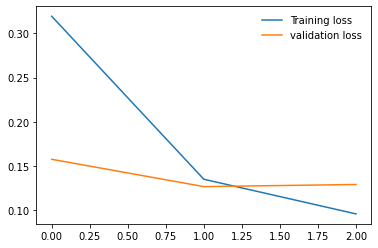

In [15]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [16]:
investigated_sample = X_test.iloc[0]["feature_text"]+" "+X_test.iloc[0]["pn_history"]

In [17]:
investigated_sample

'insomnia a 45 y/o f came to the clinic c/o nervousness. started gradually for the first time 3-4 weeks ago and since it started it is getting progressively worse. describes it as anxiety over work achievements, constant throughout the day, relate to change in her work from research to lectures, worsen before the lectures and no improvements factors. associated w/ decreased apetite, headache and difficulty falling asleep. denies fever, chills, nausea, vomit, changes in weight, weakness, numbness, dizziness, palpitations, sweating or tremors. \r\n\r\nros: negative, except as above; pmhx: none; psh: none; all: nkda; meds: tylenol for headaches; fh: non relevant; sh: married. sexually active w/ husband. works as a english professor. no h/o smoking or illicit drug use. etoh: occ.; caffeine: 5-6 cupps/day.'

In [18]:
vals = []
class Pipe():
    def __init__(self, idx):
        self.idx = idx
        pass
    def __call__(self, x):
#         print(x.shape)
        X = torch.tensor([tokenizer(x.tolist(), truncation = hyperparameters['truncation'],
            max_length = hyperparameters['max_length'],
            padding = hyperparameters['padding'],
        )['input_ids']]).to(DEVICE)
        y = torch.sigmoid(model(X[0])).detach().cpu().numpy()
        return y[:,self.idx]
for i in tqdm(range(0,416)):
    pipe = Pipe(i)
    explainer = explainer = shap.explainers.Permutation(pipe, shap.maskers.Text(tokenizer=tokenizer), max_evals = 832)
    shap_values = explainer([investigated_sample])

    vals.append(shap_values)

  0%|          | 0/416 [00:00<?, ?it/s]


Permutation explainer: 2it [00:15, 15.32s/it]               

Permutation explainer: 2it [00:13, 13.77s/it]               

Permutation explainer: 2it [00:13, 13.75s/it]               

Permutation explainer: 2it [00:13, 13.78s/it]               

Permutation explainer: 2it [00:13, 13.72s/it]               

Permutation explainer: 2it [00:13, 13.77s/it]               

Permutation explainer: 2it [00:13, 13.72s/it]               

Permutation explainer: 2it [00:13, 13.72s/it]               

Permutation explainer: 2it [00:13, 13.76s/it]               

Permutation explainer: 2it [00:13, 13.71s/it]               

Permutation explainer: 2it [00:13, 13.78s/it]               

Permutation explainer: 2it [00:13, 13.71s/it]               

Permutation explainer: 2it [00:13, 13.78s/it]               

Permutation explainer: 2it [00:13, 13.70s/it]               

Permutation explainer: 2it [00:13, 13.71s/it]               

Permutation explainer: 2it [00:13, 13.78s/it]               

Permuta

In [22]:
shap_vals_per_tok = np.concatenate([t.values for t in vals], axis=0)

In [24]:
shap_mt = np.transpose(shap_vals_per_tok)
import seaborn as sns

[Text(0.5, 15.0, 'seq'), Text(33.0, 0.5, 'token')]

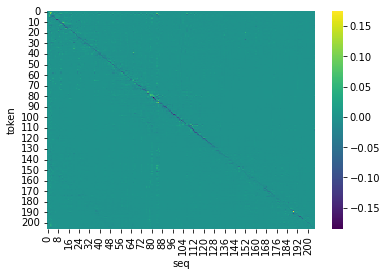

In [49]:
shap_map = sns.heatmap(shap_mt[:206,:206], cmap="viridis")
shap_map.set(xlabel="seq", ylabel="token")

In [50]:
fig = shap_map.get_figure()
fig.savefig("out.png", dpi = 900) 

In [48]:
len(vals[0].data[0])

206

<AxesSubplot:>

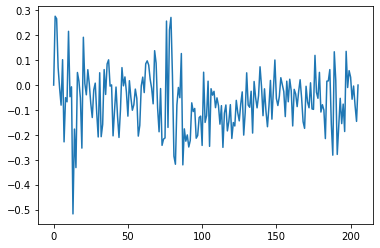

In [57]:
sns.lineplot(data=np.sum(shap_mt[:206,:206],axis=1))

In [55]:
np.sum(shap_mt[:206,:206],axis=1)

array([ 0.        ,  0.27646253,  0.26624257,  0.07047099, -0.01208657,
       -0.08065494,  0.10190415, -0.22820024, -0.05057324, -0.06724119,
        0.21585655, -0.04678804, -0.00696303, -0.51759178, -0.17674942,
       -0.33149107,  0.05053035,  0.01602967, -0.05210487, -0.25327291,
        0.19203173,  0.00593613, -0.03909202,  0.06175134,  0.00463345,
       -0.07446467, -0.13036557, -0.01930396,  0.00775615, -0.11186494,
       -0.20846567,  0.04950245, -0.20729439, -0.15835827,  0.06221103,
       -0.03768805,  0.08474216,  0.1014432 , -0.00413754,  0.0006528 ,
       -0.20400578, -0.10115524, -0.0079445 , -0.12359679, -0.21042356,
       -0.09809521,  0.07009642, -0.00304652,  0.03270647, -0.02850237,
       -0.12484876,  0.01757726, -0.04940609, -0.10116745, -0.07912704,
       -0.01619136, -0.05341059, -0.20504001, -0.16204993, -0.00306699,
        0.03196352, -0.03014811,  0.08542755,  0.09727861,  0.08053875,
        0.02300926, -0.01330169, -0.07529603,  0.13809047,  0.08